In [2]:
import torch
import torch.nn as nn
# import torchsummary
import torchmetrics
from IPython.display import clear_output
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
plt.rcParams['text.usetex'] = True

import os
from h5 import *

import time
from sklearn.model_selection import train_test_split

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [3]:
from triqs.operators import *
from triqs.gf import *
from triqs.gf.descriptors import MatsubaraToLegendre

# Loading DB

In [4]:
def load_db(filename):
    n_entries = 0
    params = 0
    smpls_list = 0
    with HDFArchive(filename, 'r') as ar:
        n_entries = ar['n_entries']
        params = ar["params"] 
        smpls_list = ar["samples"] 
    # print(params)
    data2train = [ [[sample['time2solve'], sample['averageorder']],
                    [params[smpl_id]['U'], params[smpl_id]['beta'], 
                      np.real(sample['G0_l'].data).flatten()[:30]], 
                    [ np.real(sample['G_l'].data).flatten()]]  
                  for smpl_id, sample in enumerate(smpls_list)] 
    return data2train

# db_names = [
#     'database_v4.h5',
#     'database_v5.h5',
#     'database_v6.h5'
#             ]
db_names = ['./data/databaseV8.h5',
            './data/databaseV9.h5',
            './data/databaseV10.h5',
            './data/databaseV11.h5']
data_list = [load_db(db_name) for db_name in db_names]
data = []
for dataq in data_list:
    data.extend(dataq)
print(len(data))

2000


In [5]:
U       = np.array([sample[1][0] for sample in data])
beta    = np.array([sample[1][1] for sample in data])
times   = np.array([sample[0][0] for sample in data])
order   = np.array([sample[0][1] for sample in data])

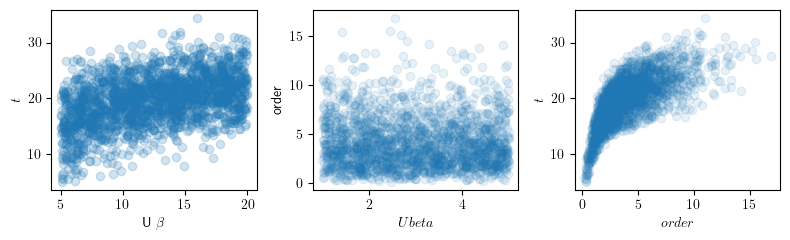

In [5]:
fig, (ax, bx, cx) = plt.subplots(  1, 3, figsize=( 8, 2.5), dpi=100)

ax.scatter(beta, times, alpha=0.2)
ax.set_xlabel(r'U $\beta$')
ax.set_ylabel(r'$t$')

# bx.scatter(U, time)
bx.scatter(U, order, alpha=0.1)
bx.set_xlabel(r'$U beta$')
bx.set_ylabel('order')

cx.scatter(order, times, alpha=0.1)
cx.set_xlabel(r'$order$')
cx.set_ylabel(r'$t$')


fig.tight_layout()
plt.show()


# Designing NN

In [6]:
def make_training_Data(db):
    X = np.array([np.hstack(sample[1]) for sample in db])
    Y = np.array([sample[2][0] for sample in db])
    params = np.array([sample[0] for sample in db])
    return X, Y, params

features, targets, params = make_training_Data(data)
print(f'in total {len(features)} rows \n\n')
print(f'num features {len(features[0])}')
print(f'num targets {len(targets[0])}')
print(f'num params {len(params[0])}\n\n')

X_train, X_test, y_train, y_test, params_train, params_test = \
    train_test_split(features, targets, params, test_size=0.3, random_state=42)

X_val, X_test, y_val, y_test, params_val, params_test = \
    train_test_split(X_test, y_test, params_test, test_size=0.33, random_state=42)


print(f'num train {len(X_train)}')
print(f'num val {len(X_val)}')
print(f'num test {len(X_test)}')


in total 2000 rows 


num features 32
num targets 30
num params 2


num train 1400
num val 402
num test 198


In [17]:
class TinyNeuralNetwork(nn.Module):
    def __init__(self, input_size=32, output_size=30):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            # Your network structure comes here
            nn.Linear(input_size, 64),  # First hidden layer
            nn.ReLU(),                    # Activation function
            nn.Linear(64, 128),           # Second hidden layer
            nn.ReLU(),                    # Activation function
            nn.Linear(128, 64),           # Third hidden layer
            nn.ReLU(),                    # Activation function
            nn.Linear(64, output_size)    # Output layer
        )    
        #     nn.Linear(784, 32),
        #     nn.BatchNorm1d(32),
        #     nn.ELU(),
        #     nn.Linear(32,10),
        #     nn.Linear(input_shape, num_classes)
        # )
        
    def forward(self, inp):       
        out = self.model(inp)
        # print(out)
        return out
    
# torchsummary.summary(TinyNeuralNetwork().to(device), (500, 42))


In [8]:
# batch generator
def get_batches(dataset, batch_size):
    X, Y, params = dataset
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield torch.Tensor(X[batch_idx]), torch.Tensor(Y[batch_idx]), params[batch_idx]


# batch_size = 4
# train_loader = get_batches((X_train, y_train), batch_size)
# test_loader = get_batches((X_test, y_test), batch_size)

# batch_size = 128
# for x_batch, y_batch in get_batches((X_train, y_train), batch_size):
#     print(x_batch.shape)
    

In [9]:
def train_model(model, batch_size, loss_func, opt, acc, n_epochs: int):
    train_loss = []
    val_loss = []
    val_accuracy = []
    
    for epoch in range(n_epochs):
        ep_train_loss = []
        ep_val_loss = []
        ep_val_accuracy = []
        start_time = time.time()

        model.train(True) # enable dropout / batch_norm training behavior
        for X_batch, y_batch, _ in get_batches((X_train, y_train, params_train), batch_size):
            # print(X_batch.shape)
            
            X_batch = X_batch.to(device, torch.float32)
            y_batch = y_batch.to(device, torch.float32)
            # train on batch: compute loss, calc grads, perform optimizer step and zero the grads
            
            # print(X_batch)
            y_pred = model(X_batch)
            # print(y_pred)
            loss = loss_func(y_pred, y_batch)
            loss.backward()
            opt.step()
            opt.zero_grad()

            ep_train_loss.append(loss.item())

        
        model.train(False) # disable dropout / use averages for batch_norm
        with torch.no_grad():
            for X_batch, y_batch, _ in get_batches((X_val, y_val, params_val), batch_size):
                # move data to target device
                
                X_batch = X_batch.to(device, torch.float32)
                y_batch = y_batch.to(device, torch.float32)
                # compute predictions
                
                y_pred = model(X_batch)
                ep_val_loss.append( loss_func(y_pred, y_batch) )
                ep_val_accuracy.append( acc(y_pred, y_batch))

        # print the results for this epoch:
        print(f'Epoch {epoch + 1} of {n_epochs} took {time.time() - start_time:.3f}s')

        train_loss.append(np.mean(ep_train_loss))
        val_loss.append(np.mean(ep_val_loss))
        val_accuracy.append(np.mean(ep_val_accuracy))
        
        print(f"\t  training loss: {train_loss[-1]:.6f}")
        print(f"\tvalidation loss: {val_loss[-1]:.6f}")
        print(f"\tvalidation accuracy: {val_accuracy[-1]:.3f}")

    return train_loss, val_loss, val_accuracy


def save_checkpoint(checkpoint_path, model, optimizer):
    # state_dict: a Python dictionary object that:
    # - for a model, maps each layer to its parameter tensor;
    # - for an optimizer, contains info about the optimizer’s states and hyperparameters used.
    state = {
        'state_dict': model.state_dict(),
        'optimizer' : optimizer.state_dict()}
    torch.save(state, checkpoint_path)
    print('model saved to %s' % checkpoint_path)
    
def load_checkpoint(checkpoint_path, model, optimizer):
    state = torch.load(checkpoint_path)
    model.load_state_dict(state['state_dict'])
    optimizer.load_state_dict(state['optimizer'])
    print('model loaded from %s' % checkpoint_path)


# Training NN

In [18]:
model = TinyNeuralNetwork().to(device, torch.float32)
opt =  torch.optim.Adam(model.parameters(), lr=1e-3) 
loss_func = nn.MSELoss()
acc = torchmetrics.MeanSquaredError()

In [21]:
n_epochs = 200
batch_size = 128
train_loss, test_loss, val_accuracy = train_model(model, batch_size, loss_func, opt, acc, n_epochs)

Epoch 1 of 200 took 0.031s
	  training loss: 0.000567
	validation loss: 0.000603
	validation accuracy: 0.001
Epoch 2 of 200 took 0.026s
	  training loss: 0.000567
	validation loss: 0.000546
	validation accuracy: 0.001
Epoch 3 of 200 took 0.025s
	  training loss: 0.000569
	validation loss: 0.000568
	validation accuracy: 0.001
Epoch 4 of 200 took 0.022s
	  training loss: 0.000573
	validation loss: 0.000608
	validation accuracy: 0.001
Epoch 5 of 200 took 0.022s
	  training loss: 0.000574
	validation loss: 0.000590
	validation accuracy: 0.001
Epoch 6 of 200 took 0.021s
	  training loss: 0.000578
	validation loss: 0.000584
	validation accuracy: 0.001
Epoch 7 of 200 took 0.020s
	  training loss: 0.000571
	validation loss: 0.000696
	validation accuracy: 0.001
Epoch 8 of 200 took 0.021s
	  training loss: 0.000567
	validation loss: 0.000538
	validation accuracy: 0.001
Epoch 9 of 200 took 0.020s
	  training loss: 0.000574
	validation loss: 0.000626
	validation accuracy: 0.001
Epoch 10 of 200 too

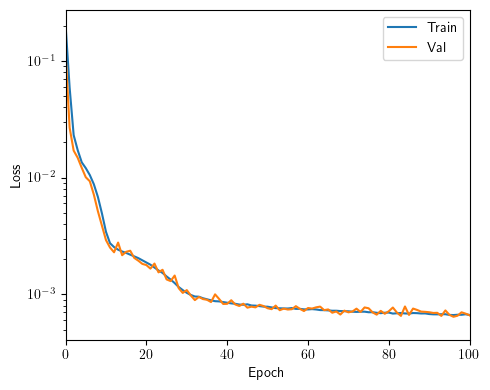

In [20]:

def plot_train_process(train_loss, test_loss, val_accuracy):
    fig, ax = plt.subplots( figsize=(5, 4))

    # ax.set_title('Loss')
    ax.plot(train_loss, label='Train')
    ax.plot(test_loss, label='Val')
    ax.set_yscale('log')

    ax.set_xlim((0, 100))
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    fig.tight_layout()

    ax.legend()

plot_train_process(train_loss, test_loss, val_accuracy)

In [22]:
save_checkpoint(checkpoint_path='./models/model_v3', model=model, optimizer=opt)

model saved to ./models/model_v3


In [19]:
load_checkpoint(checkpoint_path='./models/model_v3', model=model, optimizer=opt)

model loaded from ./models/model_v3


/tmp/ipykernel_18372/3687492894.py:69: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(checkpoint_path)


# Error analysis

In [20]:
batch_size = 128

ep_test_accuracy = []
model.train(False) # disable dropout / use averages for batch_norm
with torch.no_grad():
    for X_batch, y_batch, params_batch in get_batches((X_test, y_test, params_test), batch_size):
        # move data to target device
        
        X_batch = X_batch.to(device, torch.float32)
        y_batch = y_batch.to(device, torch.float32)
        # compute predictions
        
        y_pred = model(X_batch)
        print(len(params_batch), len(y_batch))
        ep_test_accuracy.append( np.concatenate( (  
            np.log(np.reshape([acc(y_pred[i], y_batch[i]).item() for i in range(len(y_batch)) ], (-1, 1) ) ), 
                                                  params_batch ), axis=1))

test_mse = np.concatenate(ep_test_accuracy, axis=0)

128 128
70 70


In [52]:
len(X_test)

198

In [23]:
# test_mse = pd.DataFrame({
#     'mse': np.random.rand(100),
#     'time': np.random.rand(100) * 100,
#     'order': np.random.randint(1, 10, size=100)
# })

# Define the number of bins for the histogram
num_bins = 10

# Create the histogram for MSE
counts, bin_edges = np.histogram(test_mse[:, 0], bins=num_bins)

# Calculate the bin indices for each data point
bin_indices = np.digitize(test_mse[:, 0], bin_edges)

# Calculate the mean 'order' and 'time' for each bin
mean_order = []
mean_time = []

for i in range(1, len(bin_edges)):
    # Get the data points corresponding to the current bin
    bin_data = test_mse[bin_indices == i]
    if len(bin_data) > 0:
        mean_order.append(bin_data[:, 2].mean())
        mean_time.append(bin_data[:, 1].mean())
    else:
        mean_order.append(0)
        mean_time.append(0)

# # Plotting
# fig, ax1 = plt.subplots( figsize=( 5,2.5), dpi=200)

# # Histogram for MSE
# ax1.hist(test_mse[:, 0], bins=num_bins, alpha=0.7, color='b')
# ax1.set_xlabel('log MSE')
# ax1.set_ylabel('Frequency (log MSE)', color='b')

# # Secondary axis for mean order and time
# ax2 = ax1.twinx()
# ax2.plot(bin_edges[:-1] + 0.5*(bin_edges[1]-bin_edges[0]), mean_order, 'r-', marker='o', label='Mean Order', linewidth=2)
# # ax2.plot(bin_edges[:-1], mean_time, 'g-', marker='x', label='Mean Time', linewidth=2)
# ax2.set_ylabel(r'$\langle n \rangle$', color='red')

# # Add legends and titles
# # fig.suptitle('MSE Histogram with Mean Order and Time')
# # ax2.legend(loc='upper right')
# # plt.savefig('./errors.pdf', dpi=200, bbox_inches='tight')

# plt.show()

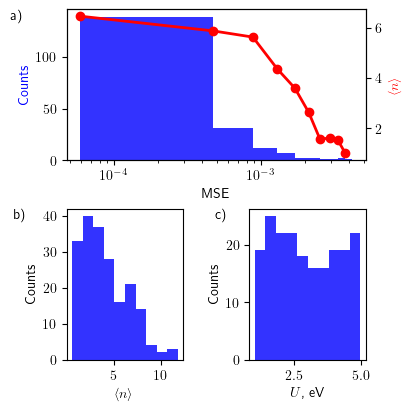

In [56]:
num_bins = 10

# Create the histogram for MSE
counts, bin_edges = np.histogram(np.exp(test_mse[:, 0]), bins=num_bins)


def plot_all():


    fig = plt.figure(constrained_layout=True, figsize=( 4, 4))
    # axs = fig.subplot_mosaic([['Left', 'TopRight'],['Left', 'BottomRight']],
    #                         gridspec_kw={'width_ratios':[2, 1]})
    
    axs = fig.subplot_mosaic([['Top', 'Top'],['BottomLeft', 'BottomRight']],
                            gridspec_kw={'width_ratios':[1, 1]})
    # axs['Top'].set_title('Spectral function')


    axs['Top'].hist(np.exp(test_mse[:, 0]), bins=num_bins, alpha=0.8, color='b')
    axs['Top'].set_xscale('log')
    
    # axs['Top'].hist(test_mse[:, 0], bins=num_bins, alpha=0.8, color='b')
    

    axs['Top'].set_xlabel('MSE')
    axs['Top'].set_ylabel('Counts', color='b')

    # Secondary axis for mean order and time
    ax2 = axs['Top'].twinx()
    ax2.plot(bin_edges[:-1] , mean_order, 
                    'r-', marker='o', label='Mean Order', linewidth=2)
    # ax2.plot(bin_edges[:-1], mean_time, 'g-', marker='x', label='Mean Time', linewidth=2)
    ax2.set_ylabel(r'$\langle n \rangle$', color='red')

    # axs['Top'].set_xlim((-1, 1))
    # axs['Top'].set_ylim((0, max(np.max(A0)*1.5,  np.max(A0)*1.5) ))
    # axs['Top'].set_xlabel(r'$E - E_f$(eV)')
    # axs['Top'].set_ylabel('Density of States (DOS)')
    axs['Top'].text(-0.15, 1.0, 'a)', transform=axs['Top'].transAxes,
        fontsize=10, fontweight='normal', va='top', ha='right')
    
    # axs['Top'].legend(prop={'size': 10}, frameon=False)  

    # plt.legend()

    #################################################################################################    
    # axs['BottomLeft'].set_title('Plot Top Right')
    axs['BottomLeft'].hist(params_test[:, 1], density=False, alpha=0.8,  color='b')

    axs['BottomLeft'].set_xlabel(r'$\langle n \rangle$')
    axs['BottomLeft'].set_ylabel(r'Counts')
    # axs['BottomLeft'].set_xlim((0, sample.beta))
    
    axs['BottomLeft'].text(-0.35, 1.0, 'b)', transform=axs['BottomLeft'].transAxes,
        fontsize=10, fontweight='normal', va='top', ha='right')
    
    #################################################################################################    
    # axs['BottomRight'].set_title('Legendre')
    axs['BottomRight'].hist(X_test[:, 0], density=False,alpha=0.8,  color='b')
    
    axs['BottomRight'].set_xlabel(r'$U$, eV')
    axs['BottomRight'].set_ylabel('Counts')
    # axs['BottomRight'].set_xlim((0, 10))
    
    
    axs['BottomRight'].text(-0.2, 1.0, 'c)', transform=axs['BottomRight'].transAxes,
        fontsize=10, fontweight='normal', va='top', ha='right')
    
    
    plt.savefig('./pics/dispersion.pdf', dpi=200, bbox_inches='tight')

    plt.show()


plot_all()